In [43]:
import openai
import faiss
import numpy as np
import sqlite3
import os
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Set up your OpenAI API key
openai.api_key = 'sk-ko4mD0G5q5eQe7c_mzU2rd5jJnQbWxGCIThHBbZ_dnT3BlbkFJA8DjlC9WP2q3D2IMvaEKuQkWHQlPewnDjHbDr45NwA' 

# Step 1: Extract schema metadata, including foreign key relationships
def extract_schema_from_db(db_file):
    if not os.path.exists(db_file):
        print(f"Database file not found: {db_file}")
        return None

    conn = sqlite3.connect(db_file)
    cursor = conn.cursor()

    # Get all table names from the database
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
    tables = cursor.fetchall()

    schema = {}
    for table in tables:
        table_name = table[0]
        cursor.execute(f"PRAGMA table_info({table_name});")
        columns = cursor.fetchall()

        schema[table_name] = {}
        for col in columns:
            schema[table_name][col[1]] = col[2]  # Store column name and type

    conn.close()
    return schema

def extract_foreign_key_relations(db_file):
    if not os.path.exists(db_file):
        print(f"Database file not found: {db_file}")
        return None

    conn = sqlite3.connect(db_file)
    cursor = conn.cursor()

    foreign_keys = {}

    # Get all table names from the database
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
    tables = cursor.fetchall()

    for table in tables:
        table_name = table[0]
        cursor.execute(f"PRAGMA foreign_key_list({table_name});")
        keys = cursor.fetchall()

        for key in keys:
            foreign_keys.setdefault(table_name, []).append({
                "from": key[3],  # Column in the current table
                "to_table": key[2],  # Table that is referenced
                "to_column": key[4]  # Column in the referenced table
            })

    conn.close()
    return foreign_keys

# Step 2: Vectorize schema metadata and store it in FAISS
def create_vector_db_from_schema(schema):
    schema_embeddings = []
    column_descriptions = []

    for table, columns in schema.items():
        for column_name, column_type in columns.items():
            description = f"Table {table}, Column {column_name}, Type {column_type}"
            column_descriptions.append(description)
            
            embedding = openai.Embedding.create(input=description, model="text-embedding-ada-002")['data'][0]['embedding']
            schema_embeddings.append(embedding)

    schema_embeddings = np.array(schema_embeddings).astype('float32')

    d = schema_embeddings.shape[1]
    index = faiss.IndexFlatIP(d)
    index.add(schema_embeddings)

    faiss.write_index(index, "schema_index.faiss")
    np.save("column_descriptions.npy", column_descriptions)

    return index

# Step 3: Retrieve relevant schema columns based on user query
def retrieve_relevant_schema(query, schema_index_file="schema_index.faiss", column_descriptions_file="column_descriptions.npy", top_n=10):
    index = faiss.read_index(schema_index_file)
    column_descriptions = np.load(column_descriptions_file, allow_pickle=True)

    query_embedding = openai.Embedding.create(input=query, model="text-embedding-ada-002")['data'][0]['embedding']
    query_embedding = np.array(query_embedding).astype('float32').reshape(1, -1)

    D, I = index.search(query_embedding, len(column_descriptions))

    relevant_columns = [(column_descriptions[i], D[0][idx]) for idx, i in enumerate(I[0][:top_n])]

    return relevant_columns

# Step 4: Create the knowledge graph from foreign key relationships
def create_knowledge_graph(foreign_keys):
    G = nx.DiGraph()

    for table, relations in foreign_keys.items():
        for relation in relations:
            from_column = f"{table}.{relation['from']}"
            to_column = f"{relation['to_table']}.{relation['to_column']}"
            G.add_edge(from_column, to_column)

    return G

# Step 5: Get related tables using the knowledge graph
def get_related_tables(query_column, G):
    if query_column not in G:
        print(f"Warning: {query_column} is not in the knowledge graph.")
        return []
    
    related_tables = list(nx.bfs_edges(G, query_column))
    return related_tables

# Step 6: Generate SQL query using GPT-4 with knowledge graph
def generate_sql_with_kg(user_query, relevant_columns, schema, knowledge_graph):
    join_relations = []

    for column_desc, _ in relevant_columns:
        table_column = column_desc.split(",")[1].strip()  # Extract table.column from description
        joins = get_related_tables(table_column, knowledge_graph)
        join_relations.extend(joins)

    if not join_relations:
        print("Warning: No join relations found. Generating query without joins.")
    
    join_str = "; ".join([f"{from_} JOIN {to_}" for from_, to_ in join_relations])

    schema_str = "; ".join([f"{table}.{col}" for table, cols in schema.items() for col in cols])
    
    # Creating a precise input text for GPT-4 with a focus on SQL only
    input_text = f"Generate only a valid SQL query for the following question: '{user_query}'. Do not include any explanations or comments. The available tables and columns are: {schema_str}. Use these join relationships: {join_str}. Ensure the query uses correct joins and columns for the query."

    response = openai.ChatCompletion.create(
        model="gpt-4",
        messages=[
            {"role": "system", "content": "You are an expert in SQL generation."},
            {"role": "user", "content": input_text}
        ],
        max_tokens=150,
        n=1,
        stop=None,
        temperature=0.5,
    )

    # Strip the response to ensure it is clean SQL without explanations
    return response['choices'][0]['message']['content'].strip()

# Full pipeline remains the same


# Step 7: Execute SQL query
def execute_sql_query(db_file, query):
    if not os.path.exists(db_file):
        print(f"Database file not found: {db_file}")
        return None

    conn = sqlite3.connect(db_file)
    try:
        df = pd.read_sql_query(query, conn)
        return df
    except Exception as e:
        print(f"Error executing query: {e}\nQuery: {query}")
        return None
    finally:
        conn.close()

# Step 8: Interpret results using GPT-4
def interpret_results(results, user_query):
    if results is None or results.empty:
        return "No results to interpret."

    results_str = results.to_string(index=False)

    input_text = f"Given the following SQL query result:\n{results_str}\nBased on this data, answer the original user question: '{user_query}' as accurately and completely as possible. Also provide an analytical summary."

    response = openai.ChatCompletion.create(
        model="gpt-4",
        messages=[
            {"role": "system", "content": "You are an expert in interpreting data and providing answers based on SQL results."},
            {"role": "user", "content": input_text}
        ],
        max_tokens=300,
        n=1,
        stop=None,
        temperature=0.5,
    )

    return response['choices'][0]['message']['content'].strip()

# Step 9: Full pipeline integration
def run_pipeline(user_query, db_file):
    schema = extract_schema_from_db(db_file)
    foreign_key_relations = extract_foreign_key_relations(db_file)

    # Vectorize schema (run only once)
    if not os.path.exists("schema_index.faiss"):
        create_vector_db_from_schema(schema)

    # Retrieve relevant columns based on query
    relevant_columns = retrieve_relevant_schema(user_query)
    print(f"Relevant schema columns: {relevant_columns}")

    # Create knowledge graph from foreign key relations
    knowledge_graph = create_knowledge_graph(foreign_key_relations)

    # Generate SQL query using GPT-4 and knowledge graph
    sql_query = generate_sql_with_kg(user_query, relevant_columns, schema, knowledge_graph)
    print(f"Generated SQL Query: {sql_query}")

    # Execute SQL query
    results = execute_sql_query(db_file, sql_query)
    print(f"SQL Query Results:\n{results}")

    # Interpret the results using GPT-4
    interpretation = interpret_results(results, user_query)
    print(f"Interpretation:\n{interpretation}")


# Db file path (example)
db_file = 'chinook-database-master/ChinookDatabase/DataSources/Chinook_Sqlite.sqlite'

In [44]:
# Run the full pipeline
user_query = "List the customers who have purchased tracks from more than 2 different genres."
run_pipeline(user_query, db_file)

"""

SELECT Customer.FirstName, Customer.LastName, COUNT(DISTINCT Genre.Name) AS GenreCount
FROM Customer
JOIN Invoice ON Customer.CustomerId = Invoice.CustomerId
JOIN InvoiceLine ON Invoice.InvoiceId = InvoiceLine.InvoiceId
JOIN Track ON InvoiceLine.TrackId = Track.TrackId
JOIN Genre ON Track.GenreId = Genre.GenreId
GROUP BY Customer.CustomerId
HAVING GenreCount > 2;


"""

Relevant schema columns: [('Table Track, Column GenreId, Type INTEGER', 0.7557802), ('Table Track, Column Composer, Type NVARCHAR(220)', 0.74347293), ('Table Genre, Column GenreId, Type INTEGER', 0.7421865), ('Table Track, Column UnitPrice, Type NUMERIC(10,2)', 0.74183726), ('Table Track, Column AlbumId, Type INTEGER', 0.74173015), ('Table Track, Column TrackId, Type INTEGER', 0.7378788), ('Table PlaylistTrack, Column TrackId, Type INTEGER', 0.73525953), ('Table Customer, Column Company, Type NVARCHAR(80)', 0.73454136), ('Table Customer, Column CustomerId, Type INTEGER', 0.73365843), ('Table Album, Column ArtistId, Type INTEGER', 0.7321495)]
Generated SQL Query: SELECT Customer.FirstName, Customer.LastName
FROM Customer
JOIN Invoice ON Customer.CustomerId = Invoice.CustomerId
JOIN InvoiceLine ON Invoice.InvoiceId = InvoiceLine.InvoiceId
JOIN Track ON InvoiceLine.TrackId = Track.TrackId
GROUP BY Customer.CustomerId
HAVING COUNT(DISTINCT Track.GenreId) > 2;
SQL Query Results:
    FirstNa

'\n\nSELECT Customer.FirstName, Customer.LastName, COUNT(DISTINCT Genre.Name) AS GenreCount\nFROM Customer\nJOIN Invoice ON Customer.CustomerId = Invoice.CustomerId\nJOIN InvoiceLine ON Invoice.InvoiceId = InvoiceLine.InvoiceId\nJOIN Track ON InvoiceLine.TrackId = Track.TrackId\nJOIN Genre ON Track.GenreId = Genre.GenreId\nGROUP BY Customer.CustomerId\nHAVING GenreCount > 2;\n\n\n'

In [17]:
# Run the full pipeline
user_query = " List all employees who have sold tracks to customers in the same city."
run_pipeline(user_query, db_file)

"""

SELECT Employee.FirstName, Employee.LastName, Customer.FirstName AS CustomerFirstName, Customer.LastName AS CustomerLastName, Customer.City
FROM Employee
JOIN Customer ON Employee.City = Customer.City
JOIN Invoice ON Customer.CustomerId = Invoice.CustomerId
JOIN InvoiceLine ON Invoice.InvoiceId = InvoiceLine.InvoiceId
WHERE Employee.EmployeeId = InvoiceLine.InvoiceId;



"""

Extracted Schema: {'Album': {'AlbumId': 'INTEGER', 'Title': 'NVARCHAR(160)', 'ArtistId': 'INTEGER'}, 'Artist': {'ArtistId': 'INTEGER', 'Name': 'NVARCHAR(120)'}, 'Customer': {'CustomerId': 'INTEGER', 'FirstName': 'NVARCHAR(40)', 'LastName': 'NVARCHAR(20)', 'Company': 'NVARCHAR(80)', 'Address': 'NVARCHAR(70)', 'City': 'NVARCHAR(40)', 'State': 'NVARCHAR(40)', 'Country': 'NVARCHAR(40)', 'PostalCode': 'NVARCHAR(10)', 'Phone': 'NVARCHAR(24)', 'Fax': 'NVARCHAR(24)', 'Email': 'NVARCHAR(60)', 'SupportRepId': 'INTEGER'}, 'Employee': {'EmployeeId': 'INTEGER', 'LastName': 'NVARCHAR(20)', 'FirstName': 'NVARCHAR(20)', 'Title': 'NVARCHAR(30)', 'ReportsTo': 'INTEGER', 'BirthDate': 'DATETIME', 'HireDate': 'DATETIME', 'Address': 'NVARCHAR(70)', 'City': 'NVARCHAR(40)', 'State': 'NVARCHAR(40)', 'Country': 'NVARCHAR(40)', 'PostalCode': 'NVARCHAR(10)', 'Phone': 'NVARCHAR(24)', 'Fax': 'NVARCHAR(24)', 'Email': 'NVARCHAR(60)'}, 'Genre': {'GenreId': 'INTEGER', 'Name': 'NVARCHAR(120)'}, 'Invoice': {'InvoiceId': 

'\n\nSELECT Employee.FirstName, Employee.LastName, Customer.FirstName AS CustomerFirstName, Customer.LastName AS CustomerLastName, Customer.City\nFROM Employee\nJOIN Customer ON Employee.City = Customer.City\nJOIN Invoice ON Customer.CustomerId = Invoice.CustomerId\nJOIN InvoiceLine ON Invoice.InvoiceId = InvoiceLine.InvoiceId\nWHERE Employee.EmployeeId = InvoiceLine.InvoiceId;\n\n\n\n'

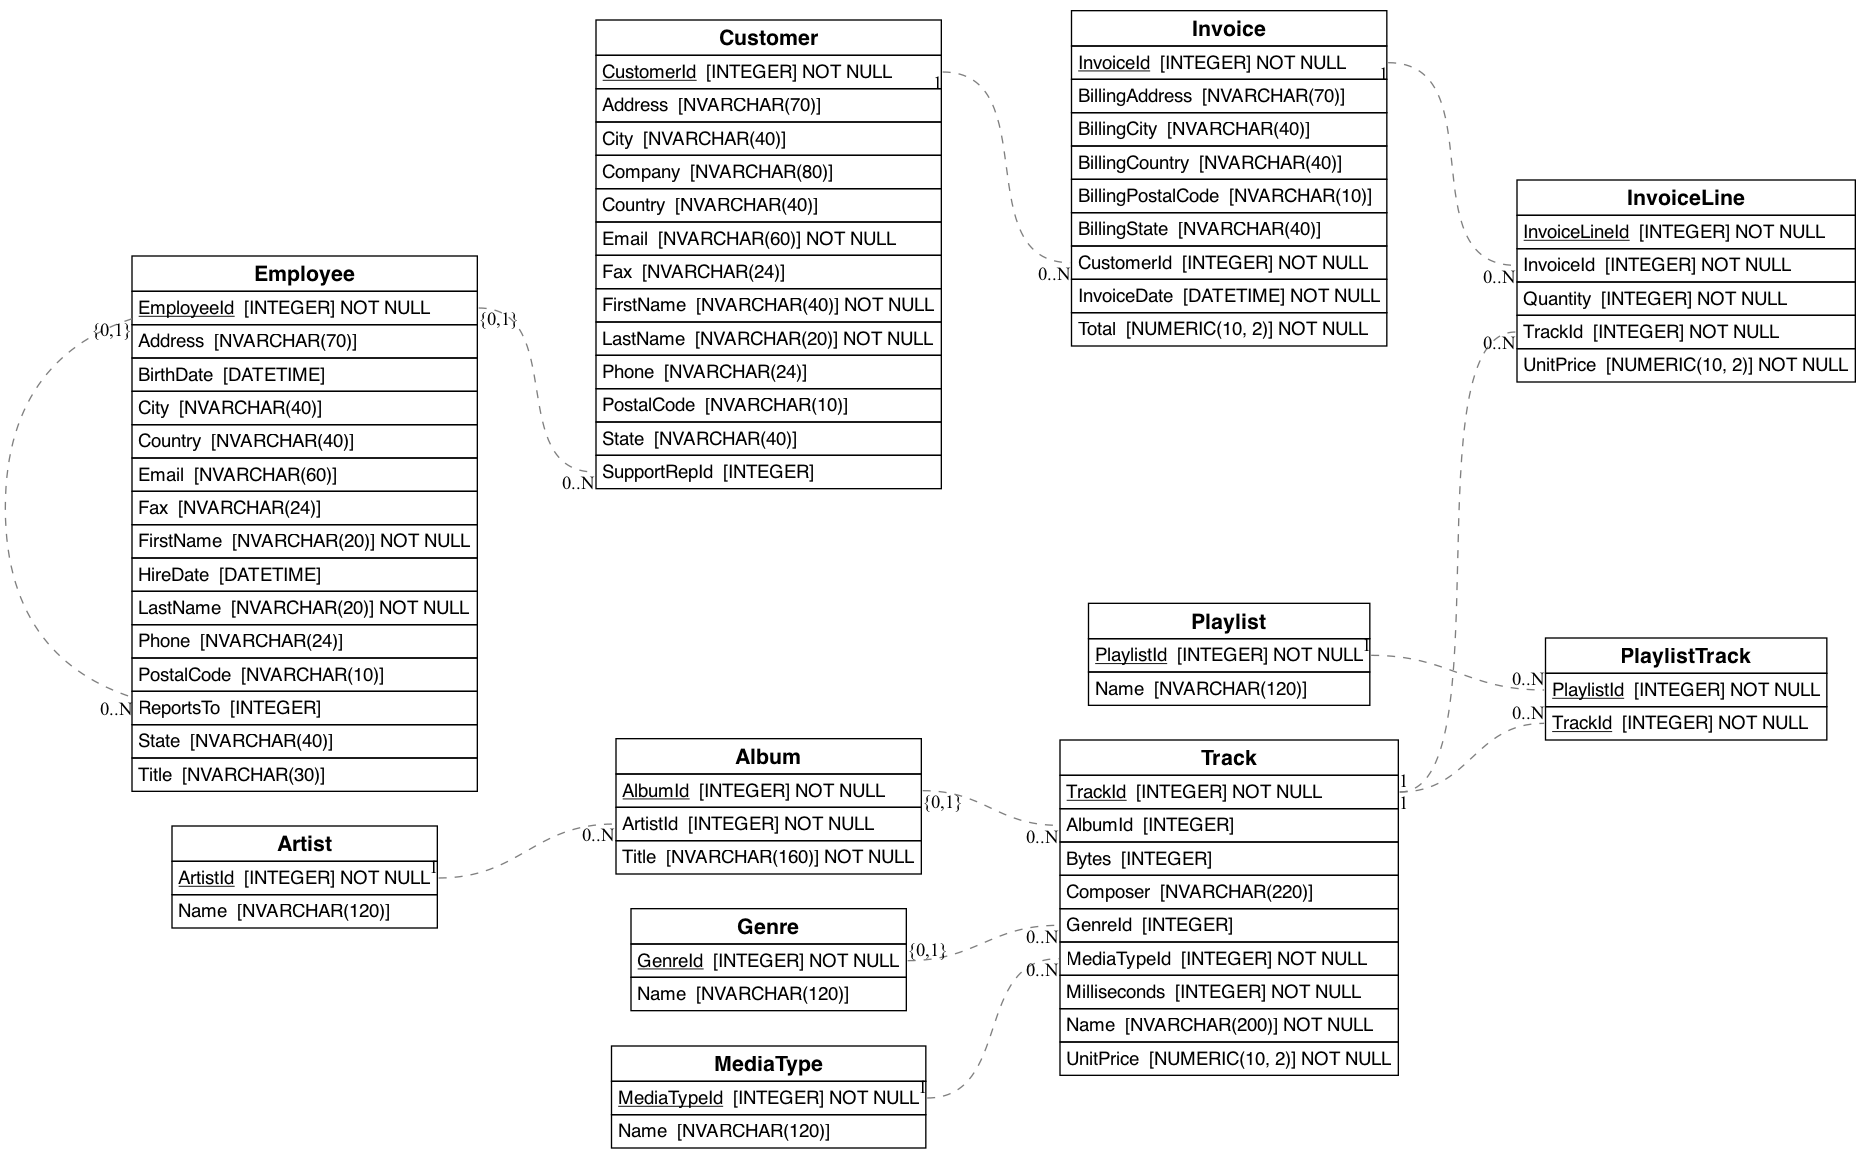

In [31]:
# Import the necessary libraries
from eralchemy import render_er
from IPython.display import Image
import os

# Get the absolute path to your SQLite database
db_path = os.path.abspath('chinook-database-master/ChinookDatabase/DataSources/Chinook_Sqlite.sqlite')

# Form the correct SQLAlchemy URL
db_url = f'sqlite:///{db_path}'

# Generate ERD and save it as a PNG image
output_file = 'chinook_erd.png'
render_er(db_url, output_file)

# Display the generated ERD
img = Image(output_file)
img
